# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT GPS Tracker dataset.



In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 641.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 13.1 MB/s eta 0:00:00


In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, SOA
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_IoT_dataset/Train_Test_IoT_GPS_Tracker.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('Train_Test_IoT_GPS_Tracker.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,633 (248.57 KB)

 Trainable params: 63,533 (248.18 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5212 - loss: 0.6922 - val_accuracy: 0.6096 - val_loss: 0.6911
Epoch 2/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5232 - loss: 0.6916 - val_accuracy: 0.6096 - val_loss: 0.6909
Epoch 3/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5381 - loss: 0.6906 - val_accuracy: 0.6096 - val_loss: 0.6903
Epoch 4/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5427 - loss: 0.6902 - val_accuracy: 0.8239 - val_loss: 0.6902
Epoch 5/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5529 - loss: 0.6891 - val_accuracy: 0.9045 - val_loss: 0.6896
Epoch 6/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5606 - loss: 0.6884 - val_accuracy: 0.9045 - val_loss: 0.6895
Epoch 7/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5662 - loss: 0.6873 - val_accuracy: 0.9045 - val_loss: 0.6892
Epoch 8/70
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5661 - loss: 0.6871 - val_accuracy: 0.

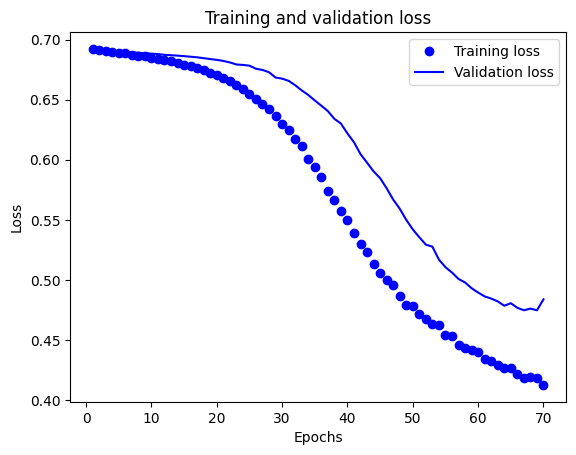

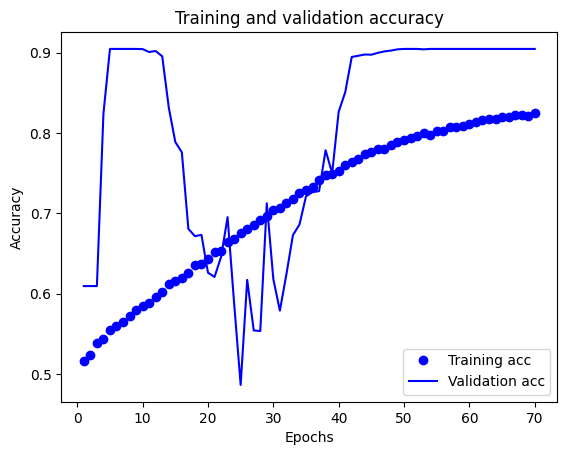


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      1527
           1       0.85      1.00      0.92      2369

    accuracy                           0.90      3896
   macro avg       0.93      0.87      0.88      3896
weighted avg       0.91      0.90      0.89      3896


Confusion Matrix
[[1120  407]
 [   0 2369]]


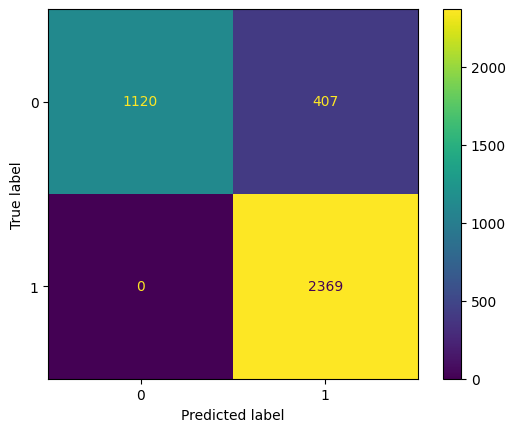

Time taken: 387.4674 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units


The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.


In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])

#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]

  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))


  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]
UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = SOA.OriginalSOA(epoch=15, pop_size=20, fc=2)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="hello/goc")
model.history.save_local_objectives_chart(filename="hello/loc")

model.history.save_global_best_fitness_chart(filename="hello/gbfc")
model.history.save_local_best_fitness_chart(filename="hello/lbfc")

model.history.save_runtime_chart(filename="hello/rtc")

model.history.save_exploration_exploitation_chart(filename="hello/eec")

model.history.save_diversity_chart(filename="hello/dc")

INFO:mealpy.bio_based.SOA.OriginalSOA:Solving single objective optimization problem.


Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.5965092480182648
Accuracy 0.39040040969848633
Accuracy 0.11088293790817261
Accuracy 0.39040040969848633
Accuracy 0.671201229095459
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.17120122909545898
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6242299675941467
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.3898870348930

INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 1, Current best: 0.29491788148880005, Global best: 0.11088293790817261, Runtime: 2157.22818 seconds


Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.29491788148880005
Accuracy 0.6095995903015137
Accuracy 0.09548252820968628
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 2, Current best: 0.09548252820968628, Global best: 0.09548252820968628, Runtime: 2165.57122 seconds


Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.5903490781784058
Accuracy 0.6095995903015137
Accuracy 0.29491788148880005
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.29491788148880005
Accuracy 0.6095995903015137


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 3, Current best: 0.29491788148880005, Global best: 0.09548252820968628, Runtime: 2041.88948 seconds


Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 4, Current best: 0.29491788148880005, Global best: 0.09548252820968628, Runtime: 2053.12459 seconds


Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.5965092480182648
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.09548252820968628
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.3003079891204834
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.3146817088127136
Accuracy 0.39040040969848633


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 5, Current best: 0.09548252820968628, Global best: 0.09548252820968628, Runtime: 2071.68230 seconds


Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.3898870348930359
Accuracy 0.5785420835018158
Accuracy 0.20739221572875977
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.2977412939071655
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 6, Current best: 0.20739221572875977, Global best: 0.09548252820968628, Runtime: 1717.93720 seconds


Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.31211501359939575
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.09548252820968628


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 7, Current best: 0.09548252820968628, Global best: 0.09548252820968628, Runtime: 2054.80880 seconds


Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.5980492830276489
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 8, Current best: 0.29491788148880005, Global best: 0.09548252820968628, Runtime: 1893.14622 seconds


Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.5965092480182648
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.29491788148880005
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 9, Current best: 0.09548252820968628, Global best: 0.09548252820968628, Runtime: 1893.33856 seconds


Accuracy 0.09548252820968628
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 10, Current best: 0.39040040969848633, Global best: 0.09548252820968628, Runtime: 2239.65361 seconds


Accuracy 0.604722797870636
Accuracy 0.39040040969848633
Accuracy 0.6206365525722504
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.3380390405654907
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 11, Current best: 0.3380390405654907, Global best: 0.09548252820968628, Runtime: 1790.07475 seconds


Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.38655030727386475
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6701745390892029
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.6095995903015137
Accuracy 0.09727925062179565


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 12, Current best: 0.09727925062179565, Global best: 0.09548252820968628, Runtime: 1786.27585 seconds


Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.26848047971725464
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6165297627449036
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.29491788148880005
Accuracy 0.6095995903015137


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 13, Current best: 0.26848047971725464, Global best: 0.09548252820968628, Runtime: 1688.91060 seconds


Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.10138601064682007
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.2156057357788086
Accuracy 0.19815194606781006
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137
Accuracy 0.24512320756912231
Accuracy 0.39040040969848633
Accuracy 0.09548252820968628
Accuracy 0.39040040969848633
Accuracy 0.39040040969848633
Accuracy 0.6095995903015137


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 14, Current best: 0.09548252820968628, Global best: 0.09548252820968628, Runtime: 1797.02553 seconds


Accuracy 0.459445595741272
Accuracy 0.6180698275566101
Accuracy 0.36242300271987915
Accuracy 0.4614989757537842
Accuracy 0.45893222093582153
Accuracy 0.4355749487876892
Accuracy 0.5225872695446014
Accuracy 0.09548252820968628
Accuracy 0.35523611307144165
Accuracy 0.3557494878768921
Accuracy 0.21303904056549072
Accuracy 0.5487679541110992
Accuracy 0.11088293790817261
Accuracy 0.4065708518028259
Accuracy 0.5823921859264374
Accuracy 0.09548252820968628
Accuracy 0.10523611307144165
Accuracy 0.6350102722644806
Accuracy 0.610882967710495
Accuracy 0.2648870348930359


INFO:mealpy.bio_based.SOA.OriginalSOA:>>>Problem: P, Epoch: 15, Current best: 0.09548252820968628, Global best: 0.09548252820968628, Runtime: 1282.30284 seconds


Accuracy 0.09599590301513672
Solution: [2.99       1.8882204  2.05132718 2.99       2.99      ], Fitness: 0.09548252820968628
Solution: [2.99       1.8882204  2.05132718 2.99       2.99      ], Fitness: 0.09548252820968628


Solution: Solution: [2.99       1.8882204  2.05132718 2.99       2.99      ], Fitness: 0.09548252820968628


Batch Size - 32, 64, **128**

Activation - softmax, **softplus**, relu, tanh, sigmoid, hard_sigmoid, linear

Learning Rate - 0.0005, 0.001, **0.005**, 0.01, 0.05, 0.1

Filters - 25, 50, **75**

Hidden Units - 400, 512, **640**

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 2, 75)          │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 75)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 75)          │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 640)            │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,681 (307.35 KB)

 Trainable params: 78,531 (306.76 KB)

 Non-trainable params: 150 (600.00 B)

Epoch 1/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4964 - loss: 0.8013 - val_accuracy: 0.3904 - val_loss: 0.6991
Epoch 2/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5031 - loss: 0.7685 - val_accuracy: 0.6096 - val_loss: 0.6888
Epoch 3/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5006 - loss: 0.7533 - val_accuracy: 0.6096 - val_loss: 0.6796
Epoch 4/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5078 - loss: 0.7331 - val_accuracy: 0.6096 - val_loss: 0.6841
Epoch 5/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5049 - loss: 0.7226 - val_accuracy: 0.3904 - val_loss: 0.7028
Epoch 6/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5042 - loss: 0.7148 - val_accuracy: 0.3904 - val_loss: 0.7029
Epoch 7/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5102 - loss: 0.7075 - val_accuracy: 0.6096 - val_loss: 0.6846
Epoch 8/70
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4989 - loss: 0.7059 - val_accura

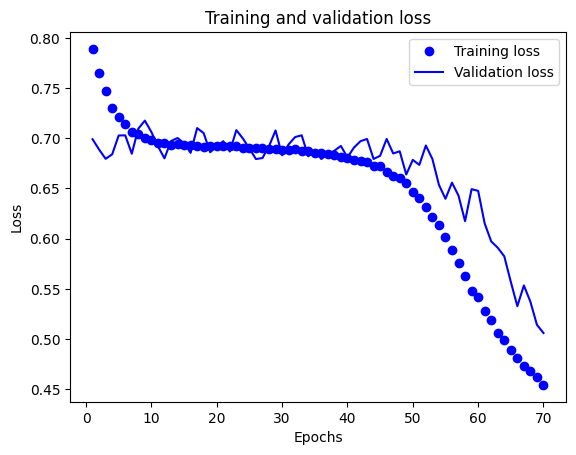

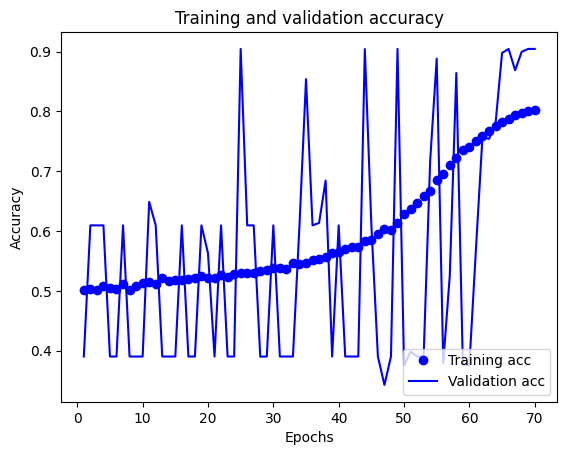


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.73      0.85      1527
           1       0.85      1.00      0.92      2369

    accuracy                           0.90      3896
   macro avg       0.93      0.87      0.88      3896
weighted avg       0.91      0.90      0.89      3896


Confusion Matrix
[[1120  407]
 [   0 2369]]


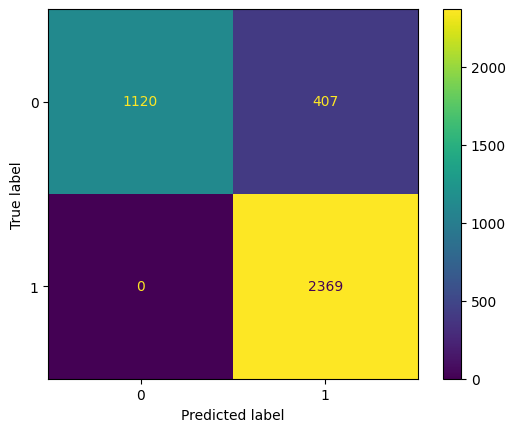

Time taken: 285.9262 seconds


In [ ]:
start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=75, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(640, activation='softplus'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.005)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=128, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")